In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.sparse import coo_matrix
import datetime
import random
import string
import scipy.io
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Batch,Data
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/final_coordinates.pkl','rb') as file:
    inp = pickle.load(file)
with open('/content/drive/MyDrive/Neural Network for Pore Formation/Data/s_list.pkl','rb') as file:
    s = pickle.load(file)

In [ ]:
inp_train, inp_val, s_train, s_val = train_test_split(inp, s, test_size=0.2, random_state=69)
inp_train, inp_test, s_train, s_test = train_test_split(inp_train, s_train, test_size=0.2, random_state=69)

In [ ]:
learning_rate = 0.0001
batch_size = 32
cutoff_radius = 10

In [ ]:
def getDataLoader(x,y):
    tensor_inp = torch.Tensor(x)
    tensor_z = torch.Tensor(y)
    dataset = TensorDataset(tensor_inp,tensor_z)
    return DataLoader(dataset, batch_size)

In [ ]:
train_dataloader = getDataLoader(inp_train, s_train)
val_dataloader = getDataLoader(inp_val, s_val)
test_dataloader = getDataLoader(inp_test, s_test)

In [ ]:
def train(
    model,
    dataset,
    optimizer,
    loss,
    length_of_set,
    is_dev=False
):
    total_loss = 0
    y_pred, y_actual = [], []
    model.train()
    for x,y in tqdm(dataset):

        if not is_dev: optimizer.zero_grad()

        x = x.to(device) # (B, 3072, 3)
        y = y.to(device)
        num_atoms = x.shape[1]
        batch_size = x.shape[0]
        distances_matrix = torch.cdist(x,x,p=2)
        adjacency_matrix = (distances_matrix < cutoff_radius).float()
        edge_list = [torch.nonzero(adjacency_matrix[i], as_tuple=False).t() for i in range(batch_size)] # (B, E, 2)

        xDash = x.view(-1, 3)
        # edge_dash = torch.tensor([])
        for i in range(len(edge_list)):
          edge_list[i][0] = edge_list[i][0]*(i+1)
          edge_list[i][1] = edge_list[i][1]*(i+1)
          edge_list[i] = torch.transpose(edge_list[i], 0, 1)

        # print(len(edge_list), edge_list[0].shape)

        edge_dash = torch.transpose(torch.cat(edge_list), 0, 1).to(device)


        # max_l = max([edge_index.shape[1] for edge_index in edge_list])
        # edge_indexes = torch.zeros(batch_size,2,max_l, dtype=torch.int64).to(device)
        # for i, edge_index in enumerate(edge_list):
        #     edge_index_p = F.pad(edge_index, [0, max_l - edge_index.shape[1]], value=3073)
        #     edge_indexes[i,:,:] = edge_index_p


        pred = model(xDash, edge_dash, len(edge_list)) # (B, 1)
        curr_loss = loss(pred, y)
        # print(curr_loss.item())
        total_loss += curr_loss.item()*len(y)/(length_of_set)

        if not is_dev:
            curr_loss.backward()
            optimizer.step()

        y_pred += pred.flatten().tolist()
        y_actual += y.flatten().tolist()

    return total_loss

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.emb = nn.Linear(in_channels, hidden_channels)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        self.fc1 = nn.Linear(out_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, 1)
        self.fc3 = nn.Linear(3072,1)
    def forward(self, x, edge_index, B):
        # print(x.shape, edge_index.shape, B)
        x = self.emb(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        # x = F.relu(x) # (32* 3072, 3)
        # x = x.view(x.size(0), -1) # ()

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = x.view(B, 3072)
        x = self.fc3(x)
        x = torch.sigmoid(x) # (B, 1)
        return x

In [ ]:
model = GCN(in_channels=3, hidden_channels=25, out_channels=25).to(device)
print(model)
loss = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.5 ** epoch)

GCN(
  (emb): Linear(in_features=3, out_features=25, bias=True)
  (conv1): GCNConv(25, 25)
  (conv2): GCNConv(25, 25)
  (fc1): Linear(in_features=25, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
  (fc3): Linear(in_features=3072, out_features=1, bias=True)
)


In [ ]:
file_name = '/content/drive/MyDrive/Neural Network for Pore Formation/GNN/1shell_10.txt'

In [ ]:
file = open(file_name, "a")
num_epochs = 6
losses = []
file.write(f"Batch Size: {batch_size}, Learning Rate: {learning_rate} \n")
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, loss, inp_train.shape[0])
    val_loss = train(model, val_dataloader, optimizer, loss, inp_val.shape[0], True)
    print(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss}')
    file.write(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss} \n')
    losses.append(val_loss)
    scheduler.step()
file.close()

100%|██████████| 252/252 [00:20<00:00, 12.20it/s]


Epoch: 1/6 train loss: 0.011680526097144218 val_loss: 0.0026417942190638515


100%|██████████| 252/252 [00:20<00:00, 12.26it/s]


Epoch: 2/6 train loss: 0.002250075945646928 val_loss: 0.0020725677706350683


100%|██████████| 252/252 [00:20<00:00, 12.28it/s]


Epoch: 3/6 train loss: 0.001908008660537741 val_loss: 0.0018834369666814322


100%|██████████| 252/252 [00:20<00:00, 12.22it/s]


Epoch: 4/6 train loss: 0.0017779471532444323 val_loss: 0.0018214886976518322


100%|██████████| 252/252 [00:20<00:00, 12.21it/s]


Epoch: 5/6 train loss: 0.0017168557136857448 val_loss: 0.0017821401679591568


100%|██████████| 252/252 [00:20<00:00, 12.29it/s]

Epoch: 6/6 train loss: 0.0016851759671013473 val_loss: 0.0017668025402678609


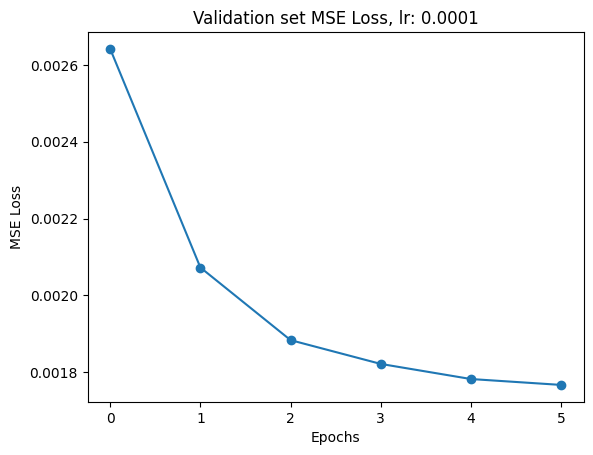

In [ ]:
plt.plot(losses, marker='o')
plt.title(f"Validation set MSE Loss, lr: {learning_rate}")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.savefig(f'1shell_{cutoff_radius}_real_loss.png', bbox_inches='tight')

In [ ]:
test_loss = train(model, test_dataloader, optimizer, loss, inp_train.shape[0], True)
print('test loss:',test_loss)

100%|██████████| 202/202 [00:17<00:00, 11.45it/s]

test loss: 0.0004277265888291509


In [ ]:
out = []
for x,y in tqdm(test_dataloader):
    x = x.to(device)
    y = y.to(device)
    distances_matrix = torch.cdist(x,x,p=2)
    adjacency_matrix = (distances_matrix < cutoff_radius).float()
    edge_list = [torch.nonzero(adjacency_matrix[i], as_tuple=False).t() for i in range(len(x))] # (B, E, 2)
    xDash = x.view(-1, 3)
    for i in range(len(edge_list)):
      edge_list[i][0] = edge_list[i][0]*(i+1)
      edge_list[i][1] = edge_list[i][1]*(i+1)
      edge_list[i] = torch.transpose(edge_list[i], 0, 1)
    edge_dash = torch.transpose(torch.cat(edge_list), 0, 1).to(device)
    outputs = model(xDash,edge_dash,len(edge_list))
    outputs = outputs.cpu().detach()
    outputs = outputs.numpy()
    out.extend(outputs)

100%|██████████| 202/202 [00:16<00:00, 12.24it/s]


In [ ]:
s_test_n = np.array(s_test)
s_test_n = s_test_n.reshape(-1)

In [ ]:
out = np.array(out)
out = out.reshape(-1)

Spearman rank correlation coefficient: 0.9892571539480577
ps-value: 0.0
Kendall rank correlation coefficient: 0.9054616369139701
pk-value: 0.0
Pearson rank correlation coefficient: 0.9902694284467067
pp-value: 0.0
R2_sqaure: 0.9805495180448275


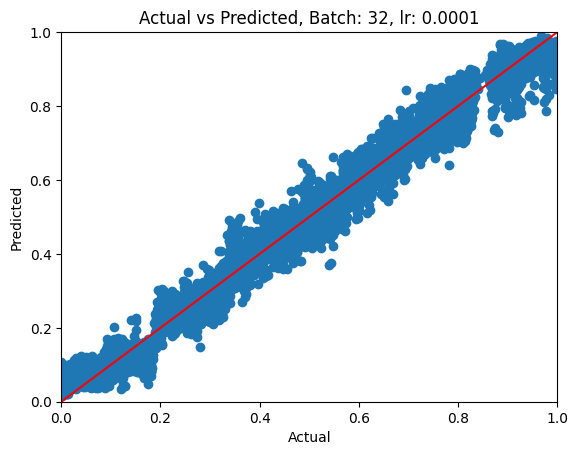

In [ ]:
plt.scatter(s_test_n,out)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title(f"Actual vs Predicted, Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')

p1 = max(max(out), max(s_test_n))
p2 = min(min(out), min(s_test_n))
plt.plot([p1, p2], [p1, p2], 'r-')
R_sqaure = r2_score(s_test_n,out)

s_corr, ps_value = spearmanr(s_test_n, out)

print("Spearman rank correlation coefficient:", s_corr)
print("ps-value:", ps_value)

k_corr, pk_value = kendalltau(s_test_n, out)

print("Kendall rank correlation coefficient:", k_corr)
print("pk-value:", pk_value)

p_corr, pp_value = pearsonr(s_test_n, out)

print("Pearson rank correlation coefficient:", p_corr)
print("pp-value:", pp_value)

print("R2_sqaure:",R_sqaure)
file = open(file_name,'a')
file.write('\n')
file.write(f"test_loss: {test_loss}\n")
file.write(f"R^2: {R_sqaure}\n")
file.write(f"Spearman rank correlation coefficient: {s_corr}\n")
file.write(f"Pearson rank correlation coefficient: {p_corr}\n")
file.write(f"Kendall rank correlation coefficient: {k_corr}\n")
file.close()
plt.savefig(f'1shell_{cutoff_radius}_real_result.png',bbox_inches='tight')